Loading and processing images...
Loaded 6270 samples across 5 classes
Train: 5016, Test: 1254

 Training Model 1: Linear SVM
Linear SVM done in 8.29s | Accuracy: 0.944, F1: 0.244

 Training Model 2: Random Forest
Random Forest done in 37.37s | Accuracy: 0.953, F1: 0.195

 Model Performance Summary:
        Model  Accuracy  F1-Score  Training Time (s)
   Linear SVM 94.417863 24.425287           8.287549
Random Forest 95.295056 19.518171          37.374485


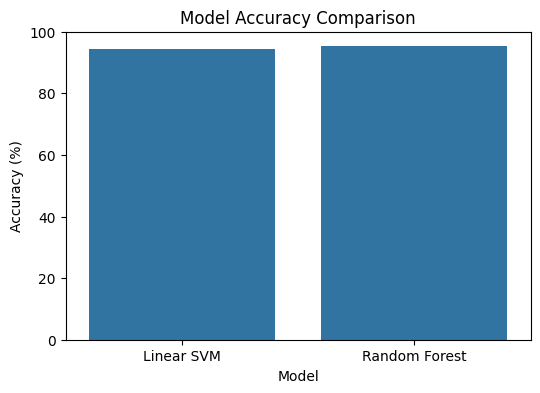

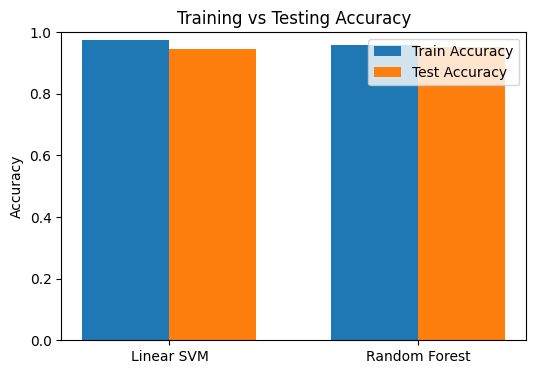

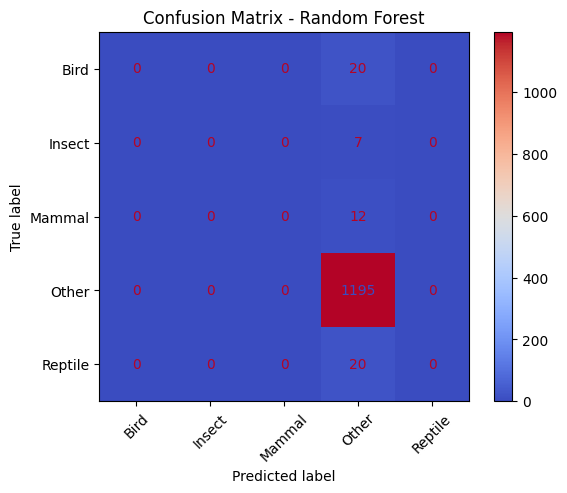

In [16]:


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
import time
import seaborn as sns


DATASET_DIR = "/content/dataset"
IMG_SIZE = (64, 64)
SAMPLE_LIMIT = 80


CLASS_MAP = {
    "Mammal": ["panthera-tigris", "pongo-abelii", "felis-silvestris-catus"],
    "Bird": ["phoenicopterus-ruber", "aquila-chrysaetos", "cygnus-olor"],
    "Reptile": ["varanus-komodoensis", "iguana-iguana", "crocodylus-niloticus"],
    "Amphibian": ["axolotl", "rana-catesbeiana"],
    "Fish": ["paracanthurus-hepatus", "clupea-harengus"],
    "Insect": ["papilio-glaucus", "mantis-religiosa"],
    "Other": ["arachnids", "jellyfish"]
}


scientific_to_class = {sci: cls for cls, names in CLASS_MAP.items() for sci in names}


def extract_hog_features(image):
    """Extract Histogram of Oriented Gradients (HOG) features."""
    if image.ndim != 2:
        raise ValueError("Image must be grayscale for HOG extraction.")
    features, _ = hog(image, orientations=8, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True)
    return features

print("Loading and processing images...")
X, y = [], []

for folder in os.listdir(DATASET_DIR):
    path = os.path.join(DATASET_DIR, folder)
    if not os.path.isdir(path):
        continue
    animal_class = scientific_to_class.get(folder, "Other")
    count = 0
    for file in os.listdir(path):
        if count >= SAMPLE_LIMIT:
            break
        img_path = os.path.join(path, file)
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, IMG_SIZE)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            features = extract_hog_features(gray)
            X.append(features)
            y.append(animal_class)
            count += 1
        except Exception as e:
            print(f"Error : {img_path}: {e}")
            continue

X = np.array(X)
y = np.array(y)
print(f"Loaded {len(X)} samples across {len(np.unique(y))} classes")


le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

print("\n Training Model 1: Linear SVM")
start = time.time()
svm_model = LinearSVC(C=0.5, max_iter=3000)
svm_model.fit(X_train, y_train)
svm_time = time.time() - start
y_pred_svm = svm_model.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='macro')

print(f"Linear SVM done in {svm_time:.2f}s | Accuracy: {acc_svm:.3f}, F1: {f1_svm:.3f}")


print("\n Training Model 2: Random Forest")
start = time.time()
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)
rf_time = time.time() - start
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print(f"Random Forest done in {rf_time:.2f}s | Accuracy: {acc_rf:.3f}, F1: {f1_rf:.3f}")


comparison = pd.DataFrame({
    "Model": ["Linear SVM", "Random Forest"],
    "Accuracy": [acc_svm * 100, acc_rf * 100],
    "F1-Score": [f1_svm * 100, f1_rf * 100],
    "Training Time (s)": [svm_time, rf_time]
})
print("\n Model Performance Summary:")
print(comparison.to_string(index=False))

plt.figure(figsize=(6, 4))
sns.barplot(x="Model", y="Accuracy", data=comparison)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.savefig("accuracy_plot.png", bbox_inches='tight')
plt.show()


train_scores = [svm_model.score(X_train, y_train), rf_model.score(X_train, y_train)]
test_scores = [acc_svm, acc_rf]

plt.figure(figsize=(6, 4))
x = np.arange(len(comparison))
width = 0.35
plt.bar(x - width/2, train_scores, width, label='Train Accuracy')
plt.bar(x + width/2, test_scores, width, label='Test Accuracy')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.xticks(x, comparison["Model"])
plt.ylim(0, 1)
plt.legend()
plt.savefig("accuracy_curve.png", bbox_inches='tight')
plt.show()

best_model = rf_model if acc_rf > acc_svm else svm_model
best_pred = y_pred_rf if acc_rf > acc_svm else y_pred_svm
best_name = "Random Forest" if acc_rf > acc_svm else "Linear SVM"

cm = confusion_matrix(y_test, best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='coolwarm', xticks_rotation=45)
plt.title(f"Confusion Matrix - {best_name}")
plt.savefig("confusion_matrix.png", bbox_inches='tight')
plt.show()



